<a href="https://colab.research.google.com/github/eentartetekunst/NGS_bioinformatics/blob/main/NGS_HW_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

In [2]:
! pip install -q condacolab

In [3]:
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [4]:
!conda install -y -c bioconda samtools

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

# All requested packages already installed.

Retrieving notices: ...working... done


In [5]:
! conda install -c bioconda subread 

Solving environment: / - \ | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - subread


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    subread-2.0.1              |       h7132678_2        22.9 MB  bioconda
    ------------------------------------------------------------
                                           Total:        22.9 MB

The following NEW packages will be INSTALLED:

  subread            bioconda/linux-64::subread-2.0.1-h7132678_2 None



subread-2.0.1        | 22.9 MB   | : 100% 1.0/1 [00:04<00:00,  4.41s/it]               
Preparing transaction: \ done
Verifying transaction: / - \ | done
Executing transaction: - done
Retrieving notices: ...working... done


In [6]:
! sudo apt install bedtools

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  bedtools
0 upgraded, 1 newly installed, 0 to remove and 12 not upgraded.
Need to get 577 kB of archives.
After this operation, 2,040 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 bedtools amd64 2.26.0+dfsg-5 [577 kB]
Fetched 577 kB in 1s (565 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-p

In [7]:
! conda install -c bioconda regtools

Solving environment: - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - regtools


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    regtools-0.6.1             |       hd03093a_0         5.0 MB  bioconda
    ------------------------------------------------------------
                                           Total:         5.0 MB

The following NEW packages will be INSTALLED:

  regtools           bioconda/linux-64::regtools-0.6.1-hd03093a_0 None



regtools-0.6.1       | 5.0 MB    | : 100% 1.0/1 [00:01<00:00,  1.68s/it]               
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - done
Retrieving notices: ...working... done


In [8]:
! sudo apt-get update
! sudo apt-get -y install hisat2

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://security.ubuntu.

In [9]:
! conda install -c bioconda stringtie 

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - stringtie


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    stringtie-2.2.1            |       ha04fe3b_3         355 KB  bioconda
    ------------------------------------------------------------
                                           Total:         355 KB

The following NEW packages will be INSTALLED:

  stringtie          bioconda/linux-64::stringtie-2.2.1-ha04fe3b_3 None



stringtie-2.2.1      | 355 KB    | : 100% 1.0/1 [00:00<00:00,  3.54it/s]                 
Preparing transaction: / done
Verifying transaction: \ done
Executing transaction: / done
Retrieving notices: ...working... done


## download genome and its annotation

In [10]:
! wget http://ftp.ensembl.org/pub/release-107/fasta/mus_musculus/dna/Mus_musculus.GRCm39.dna.chromosome.19.fa.gz #chr19 sequence
! wget http://ftp.ensembl.org/pub/release-107/gtf/mus_musculus/Mus_musculus.GRCm39.107.gtf.gz # annotation
! gzip -d Mus_musculus.GRCm39.dna.chromosome.19.fa.gz # unarchieve files

! touch chr19-annotation 
! gzip -d Mus_musculus.GRCm39.107.gtf.gz > chr19-annotation 

# select chr 19 from the annotation
! touch chr19-annotation 
! grep -P '^19\t' /content/Mus_musculus.GRCm39.107.gtf > chr19-annotation 

--2022-10-11 18:34:59--  http://ftp.ensembl.org/pub/release-107/fasta/mus_musculus/dna/Mus_musculus.GRCm39.dna.chromosome.19.fa.gz
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.193.139
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.193.139|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17732438 (17M) [application/x-gzip]
Saving to: ‘Mus_musculus.GRCm39.dna.chromosome.19.fa.gz’

Mus_musculus.GRCm39 100%[===================>]  16.91M   649KB/s    in 27s     

2022-10-11 18:35:27 (637 KB/s) - ‘Mus_musculus.GRCm39.dna.chromosome.19.fa.gz’ saved [17732438/17732438]

--2022-10-11 18:35:27--  http://ftp.ensembl.org/pub/release-107/gtf/mus_musculus/Mus_musculus.GRCm39.107.gtf.gz
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.193.139
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.193.139|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31861821 (30M) [application/x-gzip]
Saving to: ‘Mus_musculus.GRCm39.107.gtf.gz’


In [11]:
! head -n2 chr19-annotation

19	ensembl	gene	56265950	56266077	.	-	.	gene_id "ENSMUSG00000077223"; gene_version "3"; gene_name "Gm22271"; gene_source "ensembl"; gene_biotype "snoRNA";
19	ensembl	transcript	56265950	56266077	.	-	.	gene_id "ENSMUSG00000077223"; gene_version "3"; transcript_id "ENSMUST00000104035"; transcript_version "3"; gene_name "Gm22271"; gene_source "ensembl"; gene_biotype "snoRNA"; transcript_name "Gm22271-201"; transcript_source "ensembl"; transcript_biotype "snoRNA"; tag "basic"; transcript_support_level "NA (assigned to previous version 1)";


## extract coordinates of exons and splicing sites from the annotation

In [12]:
! wget https://raw.githubusercontent.com/dekoning-lab/ezmap/master/tools/HISAT2/hisat2-2.0.5-Linux/extract_splice_sites.py
! chmod a+x extract_splice_sites.py
! ./extract_splice_sites.py 

--2022-10-11 18:37:06--  https://raw.githubusercontent.com/dekoning-lab/ezmap/master/tools/HISAT2/hisat2-2.0.5-Linux/extract_splice_sites.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5021 (4.9K) [text/plain]
Saving to: ‘extract_splice_sites.py’

extract_splice_site 100%[===================>]   4.90K  --.-KB/s    in 0s      

2022-10-11 18:37:06 (43.2 MB/s) - ‘extract_splice_sites.py’ saved [5021/5021]

usage: extract_splice_sites.py [-h] [-v] [gtf_file]

Extract splice junctions from a GTF file

positional arguments:
  gtf_file       input GTF file (use "-" for stdin)

optional arguments:
  -h, --help     show this help message and exit
  -v, --verbose  also print some statistics to stderr


In [13]:
! wget https://raw.githubusercontent.com/dekoning-lab/ezmap/master/tools/HISAT2/hisat2-2.0.5-Linux/extract_exons.py
! chmod a+x extract_exons.py
! ./extract_exons.py

--2022-10-11 18:37:07--  https://raw.githubusercontent.com/dekoning-lab/ezmap/master/tools/HISAT2/hisat2-2.0.5-Linux/extract_exons.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5597 (5.5K) [text/plain]
Saving to: ‘extract_exons.py’

extract_exons.py    100%[===================>]   5.47K  --.-KB/s    in 0s      

2022-10-11 18:37:07 (40.6 MB/s) - ‘extract_exons.py’ saved [5597/5597]

usage: extract_exons.py [-h] [-v] [gtf_file]

Extract exons from a GTF file

positional arguments:
  gtf_file       input GTF file (use "-" for stdin)

optional arguments:
  -h, --help     show this help message and exit
  -v, --verbose  also print some statistics to stderr


In [14]:
 # extract splicinge sites and exons from the annotation
! ./extract_splice_sites.py chr19-annotation > chr19.ss
! ! ./extract_exons.py chr19-annotation > chr19.exons 

# 1. Прокартируйте все образцы при помощи hisat2

In [15]:
! hisat2-build --ss chr19.ss --exon chr19.exons Mus_musculus.GRCm39.dna.chromosome.19.fa base-index 

Settings:
  Output files: "base-index.*.ht2"
  Line rate: 7 (line is 128 bytes)
  Lines per side: 1 (side is 128 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Local offset rate: 3 (one in 8)
  Local fTable chars: 6
  Local sequence length: 57344
  Local sequence overlap between two consecutive indexes: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  Mus_musculus.GRCm39.dna.chromosome.19.fa
Reading reference sizes
  Time reading reference sizes: 00:00:01
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:00
  Time to read SNPs and splice sites: 00:00:00
Generation 0 (58229592 -> 58229592 nodes, 0 ranks)
COUNTED NEW NODES: 0
COUNTED TEMP NODES: 0
RESIZED NODES: 0
RESIZED NODES: 0
MADE NEW NODES: 1
Generation 1 (582388

In [16]:
%%shell 
reads_list='C14.5 B34 B14.5 C15.5 C17.5 B17.5 C34 B20 B15.5 C20' 
index='base-index'
fq='/content'

for i in ${reads_list}
do hisat2 --summary-file ${i}.log --no-softclip --no-unal -x ${index} -U ${fq}/${i}.fq.gz | samtools view -Sb - > ${i}.bam 
done

599461 reads; of these:
  599461 (100.00%) were unpaired; of these:
    49649 (8.28%) aligned 0 times
    538759 (89.87%) aligned exactly 1 time
    11053 (1.84%) aligned >1 times
91.72% overall alignment rate
599683 reads; of these:
  599683 (100.00%) were unpaired; of these:
    51939 (8.66%) aligned 0 times
    539715 (90.00%) aligned exactly 1 time
    8029 (1.34%) aligned >1 times
91.34% overall alignment rate
599672 reads; of these:
  599672 (100.00%) were unpaired; of these:
    47202 (7.87%) aligned 0 times
    540491 (90.13%) aligned exactly 1 time
    11979 (2.00%) aligned >1 times
92.13% overall alignment rate
600324 reads; of these:
  600324 (100.00%) were unpaired; of these:
    75959 (12.65%) aligned 0 times
    514263 (85.66%) aligned exactly 1 time
    10102 (1.68%) aligned >1 times
87.35% overall alignment rate
600268 reads; of these:
  600268 (100.00%) were unpaired; of these:
    59115 (9.85%) aligned 0 times
    531032 (88.47%) aligned exactly 1 time
    10121 (1.69

# 2. Соберите транскрипты при помощи stringtie для каждого образца используя аннотацию из ensembl (-G)

## for all of the samples

In [17]:
%%shell 
reads_list='C14.5 B34 B14.5 C15.5 C17.5 B17.5 C34 B20 B15.5 C20' 
# sort reads by their genomic location using samtools
for i in ${reads_list}
do samtools sort -o  ${i}.s.bam  ${i}.bam 
done

In [18]:
# -G <ref.gtf> a reference annotation file used to guide the assembly process
# build gtf annotation of reads

%%shell 
for i in ${reads_list}
do stringtie -o ${i}.annotation.gtf -G Mus_musculus.GRCm39.107.gtf ${i}.s.bam
done

In [19]:
! head B14.5.annotation.gtf

# stringtie -o B14.5.annotation.gtf -G Mus_musculus.GRCm39.107.gtf B14.5.s.bam
# StringTie version 2.2.1
19	StringTie	transcript	3133097	3137398	1000	+	.	gene_id "STRG.1"; transcript_id "STRG.1.1"; cov "2.314697"; FPKM "41.482002"; TPM "81.817490";
19	StringTie	exon	3133097	3133341	1000	+	.	gene_id "STRG.1"; transcript_id "STRG.1.1"; exon_number "1"; cov "2.361224";
19	StringTie	exon	3137331	3137398	1000	+	.	gene_id "STRG.1"; transcript_id "STRG.1.1"; exon_number "2"; cov "2.147059";
19	StringTie	transcript	3310774	3312089	1000	-	.	gene_id "STRG.2"; transcript_id "STRG.2.1"; cov "5.256909"; FPKM "94.209785"; TPM "185.815735";
19	StringTie	exon	3310774	3311635	1000	-	.	gene_id "STRG.2"; transcript_id "STRG.2.1"; exon_number "1"; cov "4.919954";
19	StringTie	exon	3311975	3312089	1000	-	.	gene_id "STRG.2"; transcript_id "STRG.2.1"; exon_number "2"; cov "7.782609";
19	StringTie	transcript	3314818	3332915	1000	-	.	gene_id "STRG.3"; transcript_id "STRG.3.1"; cov "5.645762"; FPKM "101.178474"

# 3. Перекартируйте риды используя новую аннотацию

Объединяем аннотации всех ридов

In [20]:
! touch mergelist.txt
! ls *.annotation.gtf > mergelist.txt
! cat mergelist.txt

B14.5.annotation.gtf
B15.5.annotation.gtf
B17.5.annotation.gtf
B20.annotation.gtf
B34.annotation.gtf
C14.5.annotation.gtf
C15.5.annotation.gtf
C17.5.annotation.gtf
C20.annotation.gtf
C34.annotation.gtf


In [21]:
! stringtie --merge -G Mus_musculus.GRCm39.107.gtf -o stringtie_merged.gtf mergelist.txt # merge stringtie annotations for all of the samples

### Извлекаем координаты экзонов и сайтов сплайсинга из новой аннотации

In [25]:
 # ! cat stringtie.exon | awk ' $3 == "exon" {print $1 "\t" $4 "\t" $5 "\t" $7}' > stringtie_coords.exon

In [26]:
! ./extract_splice_sites.py  stringtie_merged.gtf  >  stringtie_merged.ss
! ./extract_exons.py  stringtie_merged.gtf  >  stringtie_merged.exons 

 отбираем координаты для 19 хромосомы

In [29]:
! awk ' $1 == 19' stringtie_merged.ss > chr19_stringtie_merged.ss

In [30]:
! awk ' $1 == 19' stringtie_merged.exons > chr19_stringtie_merged.exons

In [ ]:
! head chr19_stringtie_merged.exons 

### Мы получили координаты экзонов из новой аннотации, теперь надо сделать картирование с ними:

## строим индекс по новым координатам из аннотации и картируем риды

In [ ]:
! hisat2-build --ss  chr19_stringtie_merged.ss --exon chr19_stringtie_merged.exons  Mus_musculus.GRCm39.dna.chromosome.19.fa stringtie_index

# chr19_stringtie_merged.ss -- splice sites coordinates
# chr19_stringtie_merged.exons -- exon coordinates

In [ ]:
%%shell 
reads_list='C14.5 B34 B14.5 C15.5 C17.5 B17.5 C34 B20 B15.5 C20' 
index='stringtie_index'
fq='/content'

for i in ${reads_list}
do hisat2 --summary-file ${i}.log --no-softclip --no-unal -x ${index} -U ${fq}/${i}.fq.gz | samtools view -Sb - > ${i}.bam 
done

In [ ]:
#! mkdir annotations
#! mkdir reads
#! mkdir alignments 
#! mkdir indexes

#! mv *.ht2 /content/indexes
#! mv *.log *.gz  /content/reads 
#! mv *.gtf *.exons *.exon *.ss /content/annotations
#! mv *.bam  /content/alignments

In [ ]:
! ls

alignments		 Mus_musculus.GRCm39.dna.chromosome.19.fa
annotations		 reads
chr19-annotation	 sample_data
extract_exons.py	 stringtie_coords.exon
extract_splice_sites.py  stringtie.exon
indexes			 tmp_im02Ex
mergelist.txt		 tmp_vbCcqH


#  4. Оцените экспрессию генов в каждом образце при помощи Rsubread

In [33]:
! featureCounts -a chr19-annotation -o /content/chr19_fc.txt  /content/*.s.bam
! head chr19_fc.txt


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v2.0.1

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 10 BAM files                                     ||
||                           o B14.5.s.bam                                    ||
||                           o B15.5.s.bam                                    ||
||                           o B17.5.s.bam                                    ||
||                           o B20.s.bam                         

In [34]:
! head chr19_fc.txt

# Program:featureCounts v2.0.1; Command:"featureCounts" "-a" "chr19-annotation" "-o" "/content/chr19_fc.txt" "/content/B14.5.s.bam" "/content/B15.5.s.bam" "/content/B17.5.s.bam" "/content/B20.s.bam" "/content/B34.s.bam" "/content/C14.5.s.bam" "/content/C15.5.s.bam" "/content/C17.5.s.bam" "/content/C20.s.bam" "/content/C34.s.bam" 
Geneid	Chr	Start	End	Strand	Length	/content/B14.5.s.bam	/content/B15.5.s.bam	/content/B17.5.s.bam	/content/B20.s.bam	/content/B34.s.bam	/content/C14.5.s.bam	/content/C15.5.s.bam	/content/C17.5.s.bam	/content/C20.s.bam	/content/C34.s.bam
ENSMUSG00000077223	19	56265950	56266077	-	128	0	0	0	0	0	0	0	0	0	0
ENSMUSG00000044387	19;19	23112264;23112723	23112318;23113081	+;+	414	0	0	0	0	3	0	0	0	0	0
ENSMUSG00000033863	19;19;19;19	23118590;23121008;23142047;23142047	23119623;23121336;23145498;23142835	+;+;+;+	4815	46	60	188	449	4375	54	88	85	189	2934
ENSMUSG00000080626	19	23126795	23126915	+	121	0	0	0	0	3	0	0	0	0	1
ENSMUSG00000006456	19;19;19;19;19;19;19	4850597;4850950;4

убираю информацию, которая не нужна для дальнейших шагов:

In [40]:
! touch chr19_fc.matrix.txt

In [41]:
! cut -f1,7,8,9,10,11,12,13,14,15,16 chr19_fc.txt > chr19_fc.matrix.txt

In [45]:
! tail -n +2 chr19_fc.matrix.txt > chr19_fc.matrix_trimmed.txt # удалить header line
! head chr19_fc.matrix_trimmed.txt

Geneid	/content/B14.5.s.bam	/content/B15.5.s.bam	/content/B17.5.s.bam	/content/B20.s.bam	/content/B34.s.bam	/content/C14.5.s.bam	/content/C15.5.s.bam	/content/C17.5.s.bam	/content/C20.s.bam	/content/C34.s.bam
ENSMUSG00000077223	0	0	0	0	0	0	0	0	0	0
ENSMUSG00000044387	0	0	0	0	3	0	0	0	0	0
ENSMUSG00000033863	46	60	188	449	4375	54	88	85	189	2934
ENSMUSG00000080626	0	0	0	0	3	0	0	0	0	1
ENSMUSG00000006456	740	826	651	474	298	468	673	507	520	310
ENSMUSG00000095913	15	10	8	12	5	16	7	9	5	8
ENSMUSG00000025075	1	5	9	1	0	1	0	5	4	0
ENSMUSG00000034108	194	167	180	162	144	191	191	226	176	203
ENSMUSG00000067872	9	10	16	27	43	12	12	19	30	4


In [46]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

In [47]:
colnames = [ 'B14_5', 'B15_5', 'B17_5', 'B20', 'B34','C14_5', 'C15_5', 'C17_5', 'C20', 'C34']

df = pd.read_csv('chr19_fc.matrix_trimmed.txt', sep="\t", names=colnames)

In [48]:
df.head()

,B14_5,B15_5,B17_5,B20,B34,C14_5,C15_5,C17_5,C20,C34
Geneid,/content/B14.5.s.bam,/content/B15.5.s.bam,/content/B17.5.s.bam,/content/B20.s.bam,/content/B34.s.bam,/content/C14.5.s.bam,/content/C15.5.s.bam,/content/C17.5.s.bam,/content/C20.s.bam,/content/C34.s.bam
ENSMUSG00000077223,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000044387,0,0,0,0,3,0,0,0,0,0
ENSMUSG00000033863,46,60,188,449,4375,54,88,85,189,2934
ENSMUSG00000080626,0,0,0,0,3,0,0,0,0,1


In [49]:
df = df.drop(index='Geneid')
df

,B14_5,B15_5,B17_5,B20,B34,C14_5,C15_5,C17_5,C20,C34
ENSMUSG00000077223,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000044387,0,0,0,0,3,0,0,0,0,0
ENSMUSG00000033863,46,60,188,449,4375,54,88,85,189,2934
ENSMUSG00000080626,0,0,0,0,3,0,0,0,0,1
ENSMUSG00000006456,740,826,651,474,298,468,673,507,520,310
...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000121027,6,3,4,6,0,3,3,2,4,2
ENSMUSG00000087579,2,4,3,4,10,3,0,0,3,3
ENSMUSG00000108414,524,368,227,255,85,359,272,204,245,199
ENSMUSG00000097787,29,21,22,42,25,40,40,24,45,21


In [50]:
for i in colnames:
  df[i] = df[i].astype(int) # convert dtype object to int

In [51]:
df = df.loc[~(df==0).all(axis=1)] # remove gene with zero read count in each of the samples

[Text(0.5, 0, 'B14_5'),
 Text(1.5, 0, 'B15_5'),
 Text(2.5, 0, 'B17_5'),
 Text(3.5, 0, 'B20'),
 Text(4.5, 0, 'B34'),
 Text(5.5, 0, 'C14_5'),
 Text(6.5, 0, 'C15_5'),
 Text(7.5, 0, 'C17_5'),
 Text(8.5, 0, 'C20'),
 Text(9.5, 0, 'C34')]

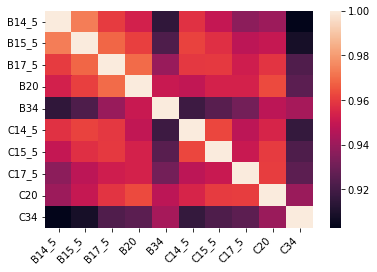

In [61]:
ax = sns.heatmap(df.corr(method='spearman'))

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')

In [58]:
import plotly.express as px
from sklearn.decomposition import PCA

features = df.columns


pca = PCA()
components = pca.fit_transform(df[features])

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(3))


fig.update_traces(diagonal_visible=False)
fig.show()

In [59]:
df.to_csv("read_counts.csv")